In [337]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astropy import coordinates as coords
from astropy import units as u
from astropy.table import Table
from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch
import astropy.wcs 
from astropy.utils.exceptions import AstropyWarning

# Function to get image of field from PanSTARRS

In [477]:
def get_panstarrs_im(ra, dec, size=640, band="g"):
    
    panstarrs_filters = ['g','r','i','z', 'y']
    if band not in panstarrs_filters:
        raise ValueError("filter must be one of "+str(pandstarrs_filters))
        
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url_search = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={band}").format(**locals())
    
    table = Table.read(url_search, format='ascii')
    filter_file = tab[tab['filter']==band]['filename'][0]
        
    url_fits = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
              "ra={ra}&dec={dec}&size={size}&format=fits&red={filter_file}").format(**locals())
    
    hdu = fits.open(url_fits)
    dat = hdu[0].data
    hdr = hdu[0].header
    
    return dat, hdr

# Function to build the VP fiber map over a field

In [474]:
def plot_fits_im(pos_field, cen_df, size=640, band="g", add_fibs=True):
    
    dat, hdr = get_panstarrs_im(pos_field.ra.deg, pos_field.dec.deg, size=size, band=band)

    # replace NaN values with zero for display
    dat[np.isnan(dat)] = 0.0

    # set contrast to something reasonable
    transform = AsinhStretch() + PercentileInterval(99.5)
    dat_t = transform(dat)
    
    warnings.simplefilter('ignore', category=AstropyWarning)
    
    im_wcs = astropy.wcs.WCS(hdr)
    
    ax = fig.add_subplot(1, 1, 1, projection=im_wcs)
    
    ax.imshow(dat_t, origin='lower', cmap='Greys_r')
    
    px1, py1 = im_wcs.wcs_pix2world(640., 640., 1)
    px2, py2 = im_wcs.wcs_pix2world(641., 640., 1)
    deg_per_pix = px1-px2
    
    field_deg = 1.7/60 #deg
    fib_deg = 4.2/3600 #deg
    field_pix = field_deg/deg_per_pix #field size in pixels
    fib_pix = fib_deg/deg_per_pix #fiber size in pixels

    x_field, y_field = astropy.wcs.utils.skycoord_to_pixel(pos_field, im_wcs)
    
    rect = patches.Rectangle((x_field-(0.5*field_pix), y_field-(0.5*field_pix)),
                             field_pix, field_pix, linewidth=1, alpha=0.7, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    
    if add_fibs:
        cen_df['x_fib'] = (cen_df['RA_offset']/3600.0/deg_per_pix)+x_field
        cen_df['y_fib'] = (cen_df['DEC_offset']/3600.0/deg_per_pix)+y_field
        
        for i in range(len(cen_df)):
            fib_num = str(int(cen_df.iloc[i]['fib_id']))
            fib = patches.Circle((cen_df.iloc[i]['x_fib'], cen_df.iloc[i]['y_fib']),
                                 fib_pix/2.0, edgecolor='blue', fill=False)
            ax.add_patch(fib)
            ax.text(cen_df.iloc[i]['x_fib']-(fib_pix/2.1), cen_df.iloc[i]['y_fib']-(fib_pix/3), fib_num,
                    color='red', fontsize=10)
            
        frame_scale = 0.75
        ax.set_xlim(x_field-(frame_scale*field_pix), x_field+(frame_scale*field_pix))
        ax.set_ylim(y_field-(frame_scale*field_pix), y_field+(frame_scale*field_pix))
            
    
    ax.set_xlabel('RA', fontsize=25)
    ax.set_ylabel('DEC', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    return ax, cen_df

# Load in the VP cen file with the fiber offsets

In [475]:
#define path to the current VP cen file
#this file defines the offsets of all the fibers in the VP field
VP_cen_file = '../VP_config/IFUcen_VP_new_27m.csv'

#open the cen file as a pandas df
cen_df = pd.read_csv(VP_cen_file, skiprows=2)
cen_df

,fib_id,RA_offset,DEC_offset,fiberd,fibersep
0,1,46.4293,-49.488,4.2,6.8
1,2,39.2864,-49.488,4.2,6.8
2,3,32.1434,-49.488,4.2,6.8
3,4,25.0004,-49.488,4.2,6.8
4,5,17.8574,-49.488,4.2,6.8
...,...,...,...,...,...
241,242,-17.8574,49.488,4.2,6.8
242,243,-25.0004,49.488,4.2,6.8
243,244,-32.1434,49.488,4.2,6.8
244,245,-39.2864,49.488,4.2,6.8


# Build a VP Fiber Map over a Field

In [480]:
#define center RA and DEC of your field and object 

#sh2_156
#obj_RA = '23h05m09.0s'
#obj_DEC = '+60d14m31.0s'
field_RA = '23h05m07.2663s'
field_DEC = '+60d14m48.306s'

#sh2_83
#field_RA = '19h24m29.5413s'
#field_DEC = '+20d47m46.355s'

#pos_obj = coords.SkyCoord(obj_RA+' '+obj_DEC, frame='icrs')
pos_field = coords.SkyCoord(field_RA+' '+field_DEC, frame='icrs')

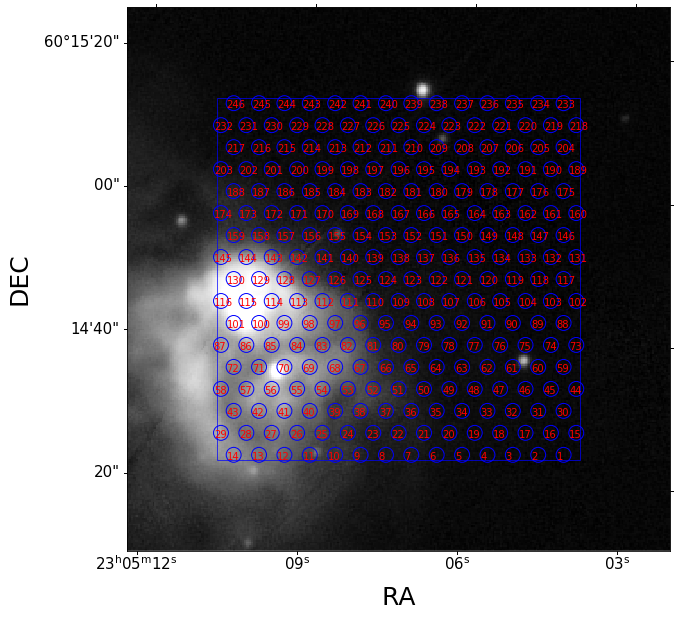

In [481]:
#plot image
fig = plt.figure(figsize=(10, 10))
ax, df_ex = plot_fits_im(pos_field, cen_df.copy(), add_fibs=True)

plt.show()

## Example of just getting the PanSTARRS image

In [482]:
#get panstarrs image

#sh2_83
field_RA = '19h24m29.5413s'
field_DEC = '+20d47m46.355s'
pos_field = coords.SkyCoord(field_RA+' '+field_DEC, frame='icrs')
print(pos_field)

dat, hdr = get_panstarrs_im(pos_field.ra.deg, pos_field.dec.deg, band='g')

<SkyCoord (ICRS): (ra, dec) in deg
    (291.12308875, 20.79620972)>


HTTPError: HTTP Error 400: fitscut error

# Example flat

In [ ]:
hdu_f = fits.open('')